In [1]:
import highspy
import numpy as np
from matplotlib import pyplot as plt
import typing as tp
import math
import random

In [2]:
def solve_dynamic_way (points : tp.List[tp.Tuple[float, float]]) -> float:
    h = highspy.Highs()
    n = len(points)
    listvars = {}
    ids = {}
    
    # create variables
    for i in range(n):
        for j in range(n):
            if (i != j):
                listvars[f"{i}->{j}"] = h.addBinary(name = f"{i}->{j}")

    for i in range(n):
        for j in range(n):
            if (i != j):
                ids[f"{i}->{j}"] = h.getColByName(f"{i}->{j}")[1]
    
    # one outgoing arrow
    for i in range(n):
        form = highspy.highs.highs_linear_expression()
        for j in range(n):
            if (i != j):
                form += listvars[f"{i}->{j}"]
        h.addConstr(1 <= form <= 1)

    # one ingoing arrow
    for i in range(n):
        form = highspy.highs.highs_linear_expression()
        for j in range(n):
            if (i != j):
                form += listvars[f"{j}->{i}"]
        h.addConstr(1 <= form <= 1)

    # making objective
    def l2_dist(p1 : tp.Tuple[float, float], p2 : tp.Tuple[float, float]) -> float:
        return math.sqrt((p1[0]-p2[0]) ** 2 + (p1[1]-p2[1]) ** 2)
    if (True):
        form = highspy.highs.highs_linear_expression()
        for i in range(n):
            for j in range(n):
                if (i != j):
                    form += listvars[f"{j}->{i}"] * l2_dist(points[j], points[i])
        h.minimize(form)

    while True:
        h.solve()
        sol : highspy.highs.HighsSolution = h.getSolution()
        plt.axis('equal')
        plt.axis('off')
    
        vis = [False]*n
        iter = 0
        cycles = []
        while (iter < n):
            cycle = []
            idxcycle = []
            cycle.append(points[iter])
            idxcycle.append(iter)
            cur = iter
            while (not vis[cur]):
                vis[cur] = True
                next = -1
                for j in range(n):
                    if (cur != j):
                        if (sol.col_value[ids[f"{cur}->{j}"]] > 0.5):
                            next = j
                cycle.append(points[next])
                idxcycle.append(next)
                cur = next
            cycle = np.asarray(cycle)
            cycles.append(idxcycle)
            plt.plot(cycle[:,0],cycle[:,1],'b')
            while (iter < n and vis[iter]):
                iter += 1
        plt.show()
        # if (input() == 'stop'):
        #     break
        if (len(cycles) > 1):
            for c in cycles:
                form = highspy.highs.highs_linear_expression()
                for i in range(len(c) - 1):
                    form += listvars[f"{c[i]}->{c[i+1]}"]
                    # print(f"{c[i]}->{c[i+1]}")
                h.addConstr(form <= (len(c) - 2))
            plt.clf()
        else:
            break

In [3]:
def solve_static_way (points : tp.List[tp.Tuple[float, float]], integ : bool) -> float:
    h = highspy.Highs()
    n = len(points)
    listvars = {}
    ids = {}
    
    # create variables
    for i in range(n):
        for j in range(n):
            if (i != j):
                listvars[f"{i}->{j}"] = h.addBinary(name = f"{i}->{j}")
    for i in range(1,n):
        if (integ): listvars[f"dummy-{i}"] = h.addIntegral(0,n-2, name = f"dummy-{i}")
        else : listvars[f"dummy-{i}"] = h.addVariable(0,n-2, name = f"dummy-{i}")

    for i in range(n):
        for j in range(n):
            if (i != j):
                ids[f"{i}->{j}"] = h.getColByName(f"{i}->{j}")[1]
    for i in range(1,n):
        ids[f"dummy-{i}"] = h.getColByName(f"dummy-{i}")[1]
    
    # one outgoing arrow
    for i in range(n):
        form = highspy.highs.highs_linear_expression()
        for j in range(n):
            if (i != j):
                form += listvars[f"{i}->{j}"]
        h.addConstr(1 <= form <= 1)

    # one ingoing arrow
    for i in range(n):
        form = highspy.highs.highs_linear_expression()
        for j in range(n):
            if (i != j):
                form += listvars[f"{j}->{i}"]
        h.addConstr(1 <= form <= 1)
    for i in range(1,n):
        for j in range(1,n):
            if (i != j):
                form = highspy.highs.highs_linear_expression()
                form += listvars[f"dummy-{j}"]
                form -= listvars[f"dummy-{i}"]
                form -= (1-listvars[f"{j}->{i}"]) * (n-1)
                h.addConstr(form <= -1)
        

    # making objective
    def l2_dist(p1 : tp.Tuple[float, float], p2 : tp.Tuple[float, float]) -> float:
        return math.sqrt((p1[0]-p2[0]) ** 2 + (p1[1]-p2[1]) ** 2)
    if (True):
        form = highspy.highs.highs_linear_expression()
        for i in range(n):
            for j in range(n):
                if (i != j):
                    form += listvars[f"{j}->{i}"] * l2_dist(points[j], points[i])
        h.minimize(form)
    
    
    h.solve()
    sol : highspy.highs.HighsSolution = h.getSolution()
    plt.axis('equal')
    plt.axis('off')

    vis = [False]*n
    iter = 0
    cycles = []
    while (iter < n):
        cycle = []
        idxcycle = []
        cycle.append(points[iter])
        idxcycle.append(iter)
        cur = iter
        while (not vis[cur]):
            vis[cur] = True
            next = -1
            for j in range(n):
                if (cur != j):
                    if (sol.col_value[ids[f"{cur}->{j}"]] > 0.5):
                        next = j
            cycle.append(points[next])
            idxcycle.append(next)
            cur = next
        cycle = np.asarray(cycle)
        cycles.append(idxcycle)
        plt.plot(cycle[:,0],cycle[:,1],'b')
        while (iter < n and vis[iter]):
            iter += 1
    plt.show()
    # if (input() == 'stop'):
    #     break
    

In [4]:
# l = [(1,1),(1,0),(0,1),(0,0),(2,2),(0.5,0.5),(0.5,1.5),(1,1.5)]

l = []

for i in range(4):
    for j in range(4):
        l.append((random.random(), random.random()))

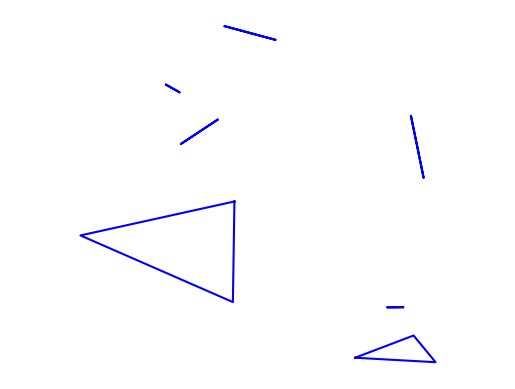

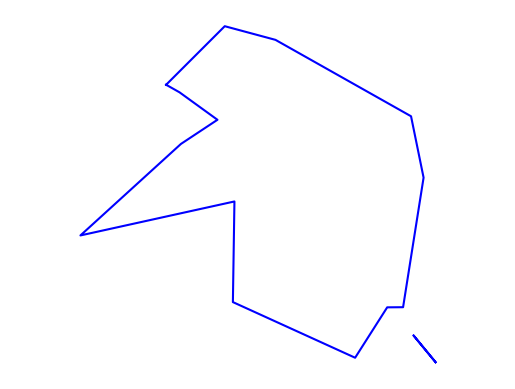

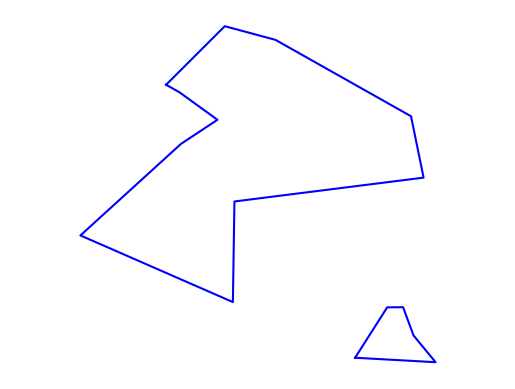

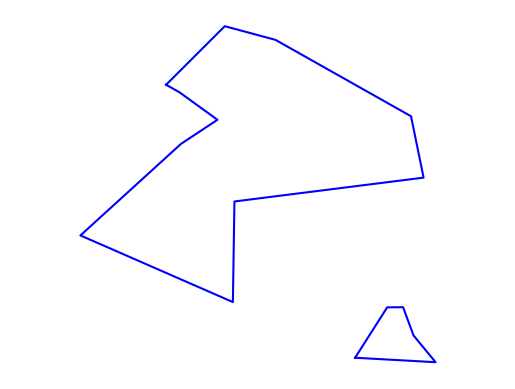

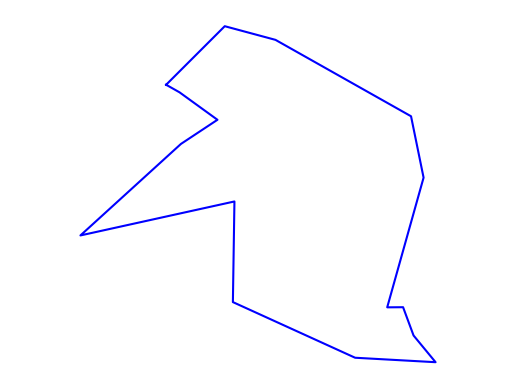

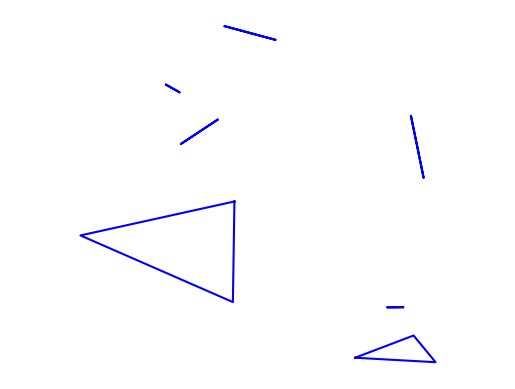

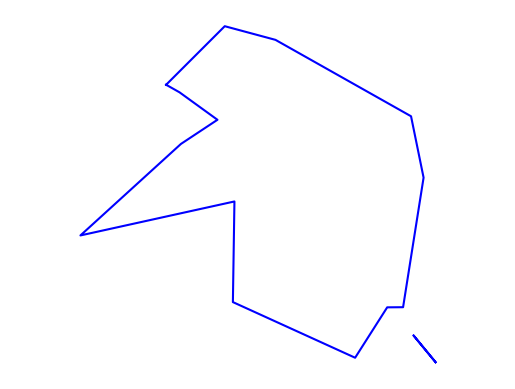

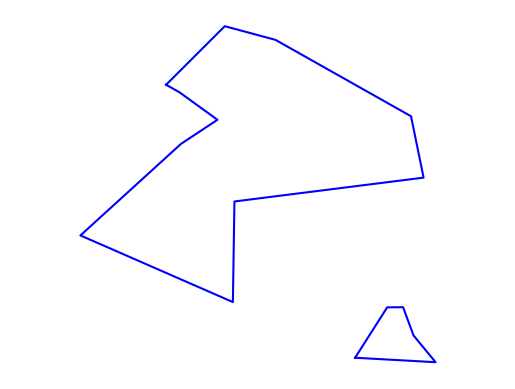

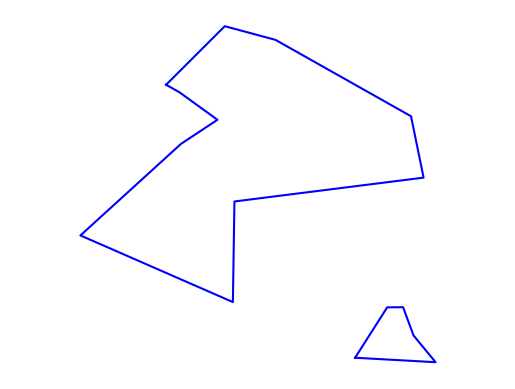

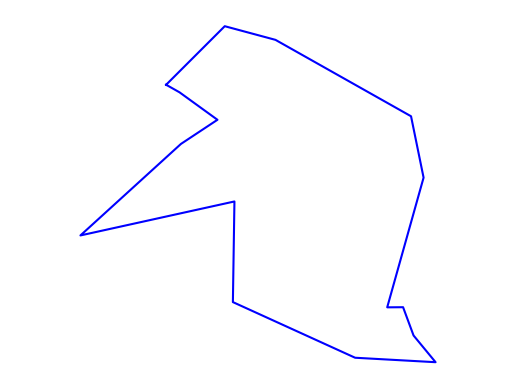

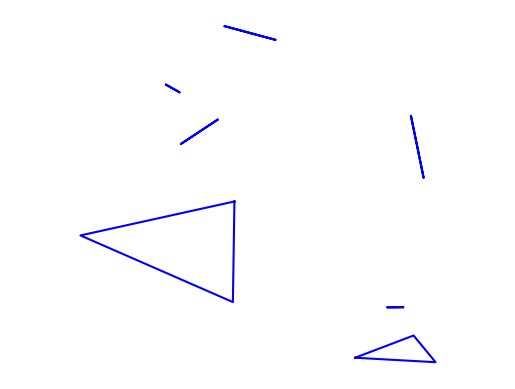

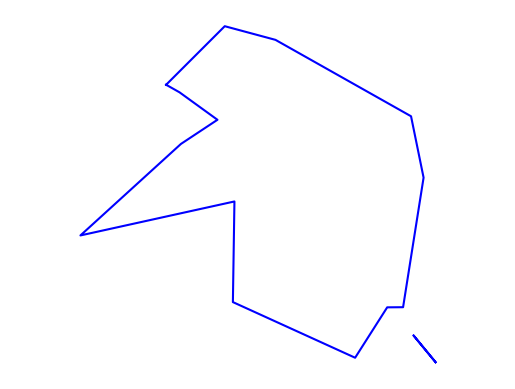

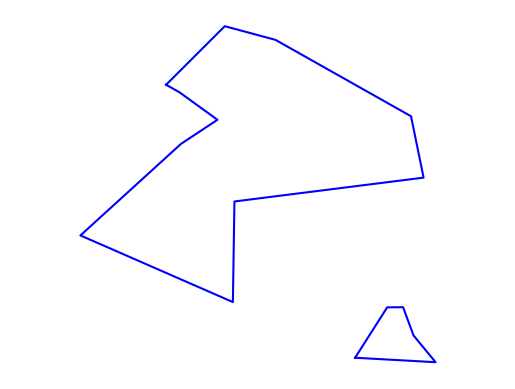

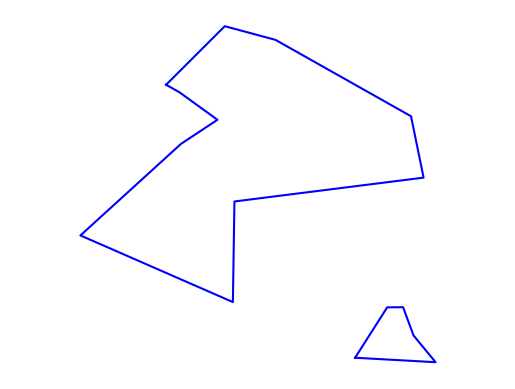

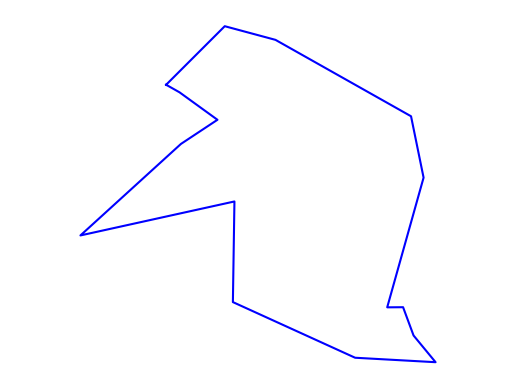

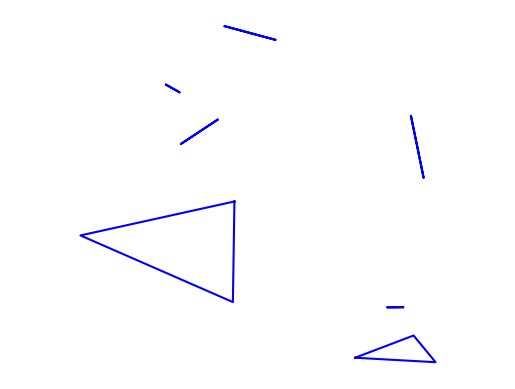

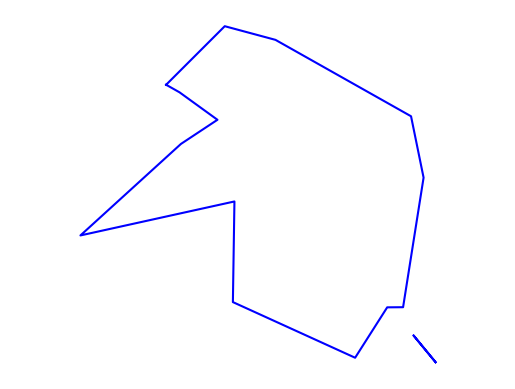

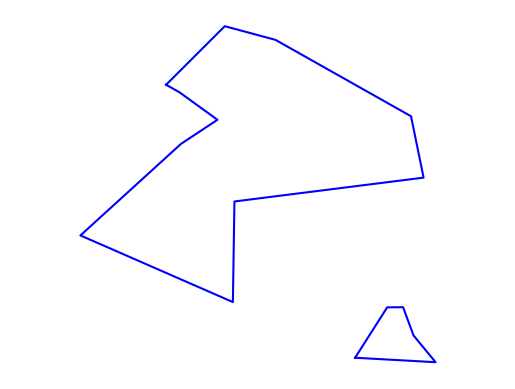

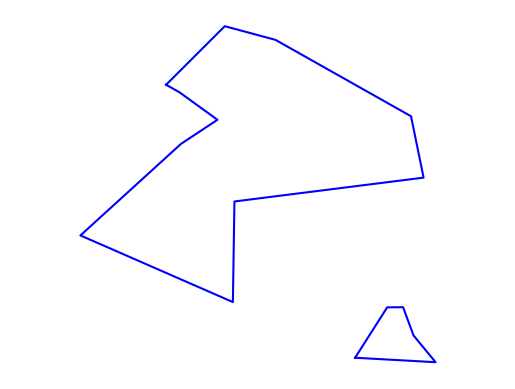

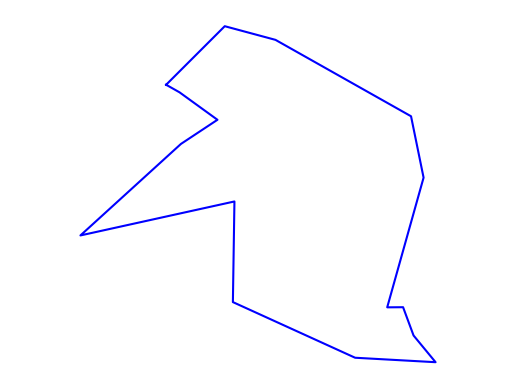

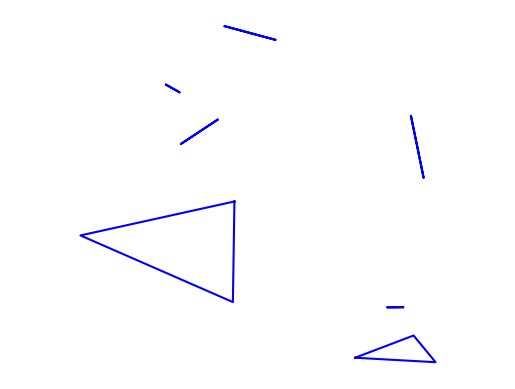

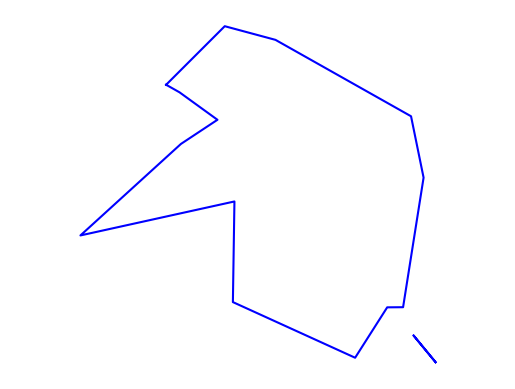

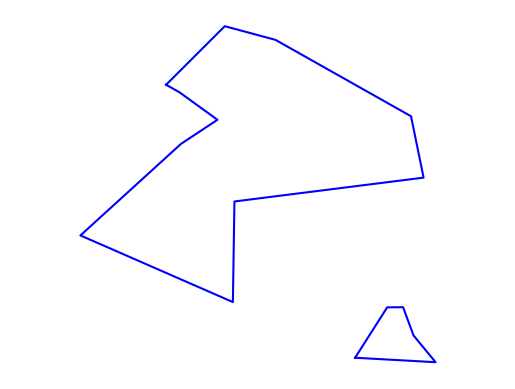

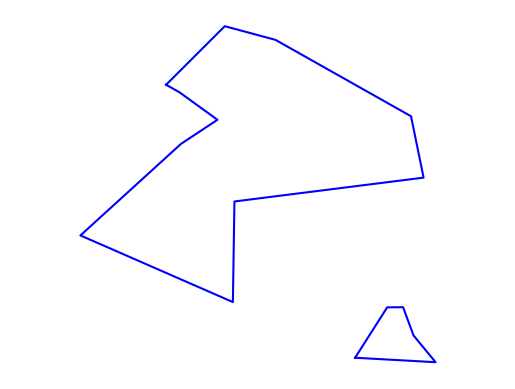

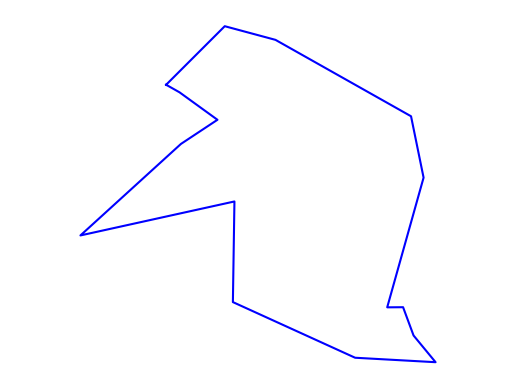

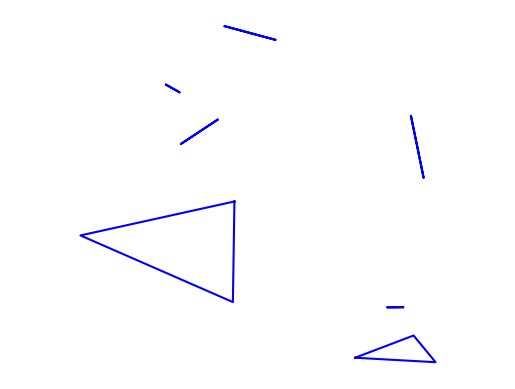

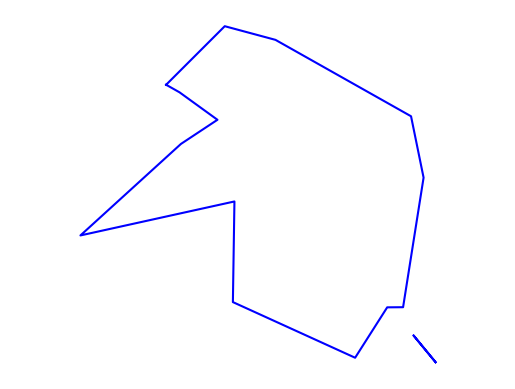

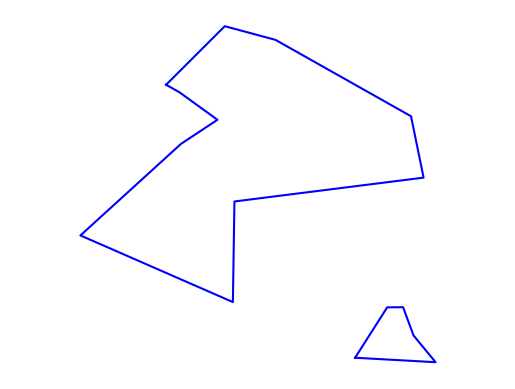

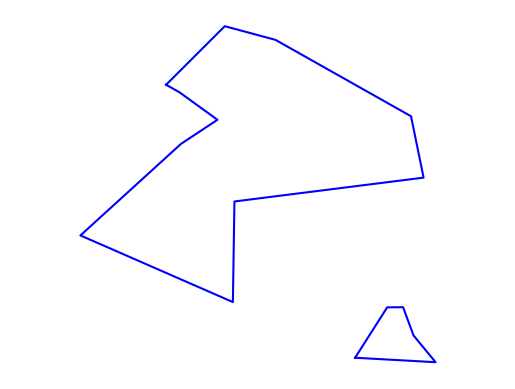

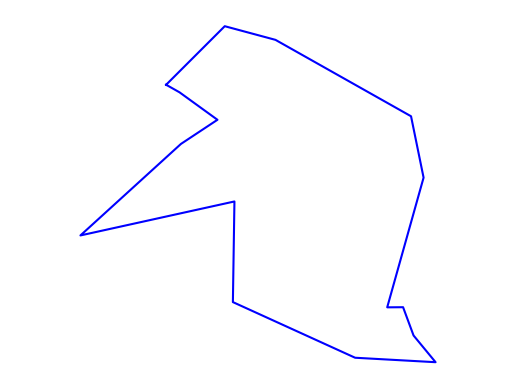

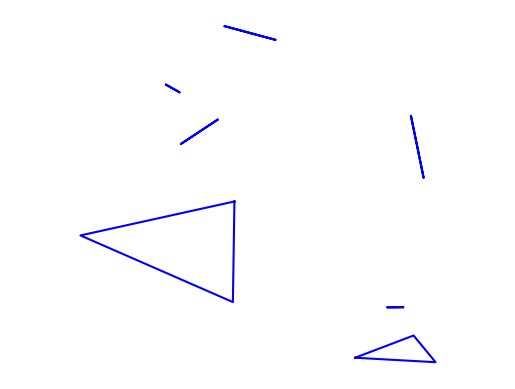

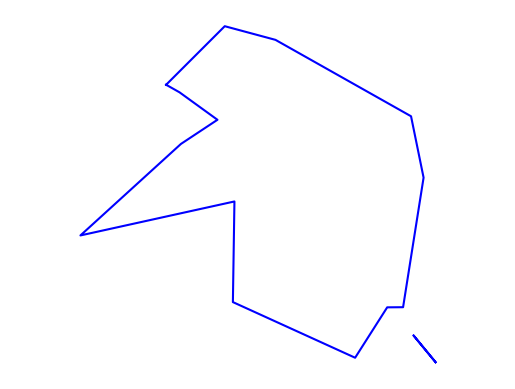

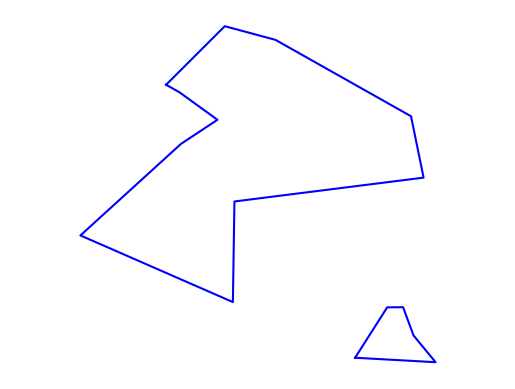

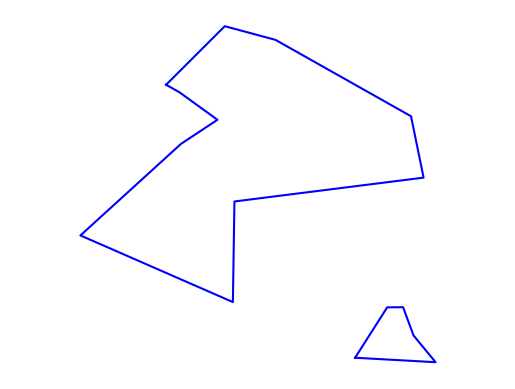

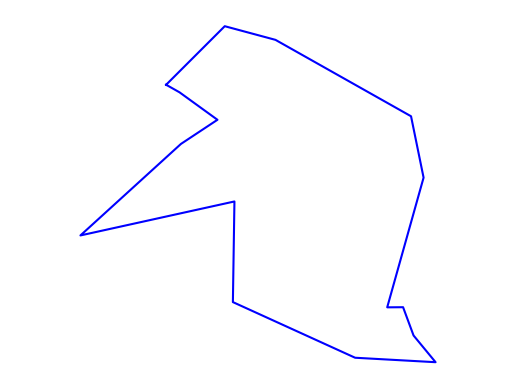

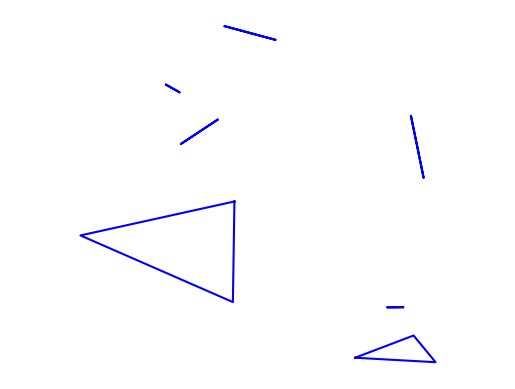

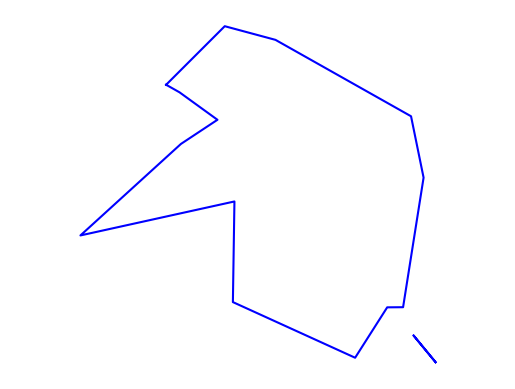

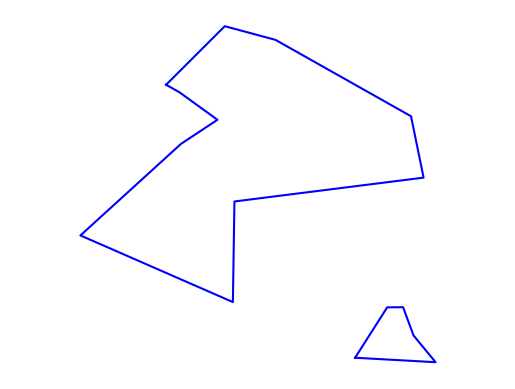

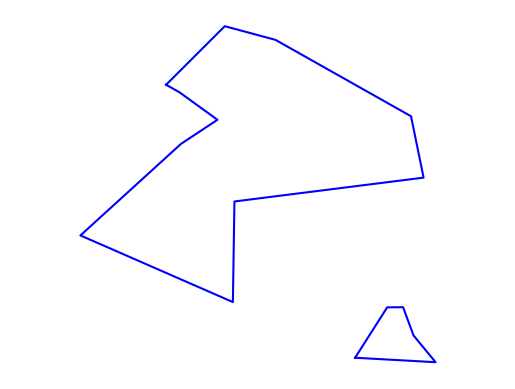

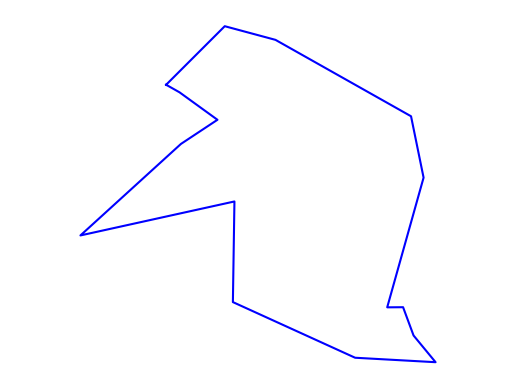

293 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%timeit solve_dynamic_way(l)

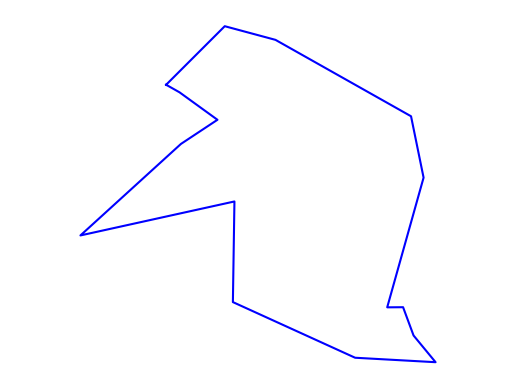

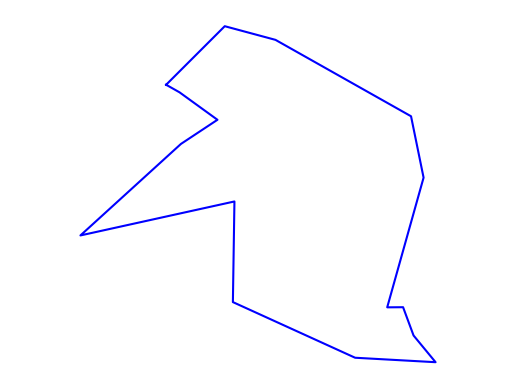

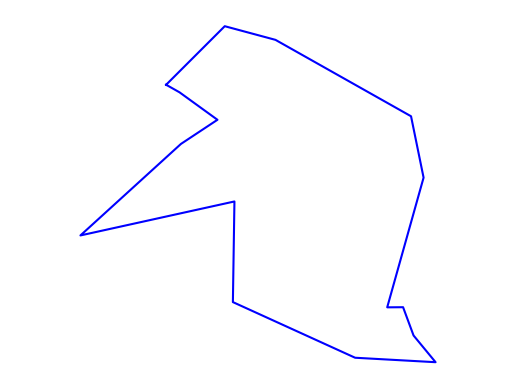

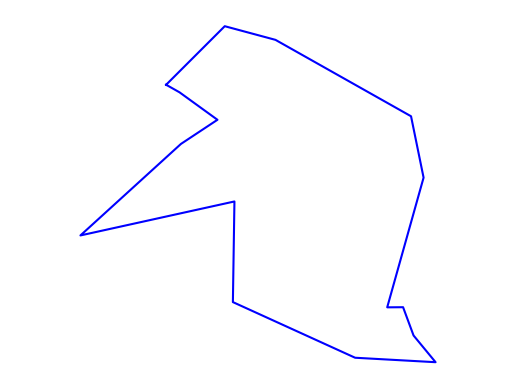

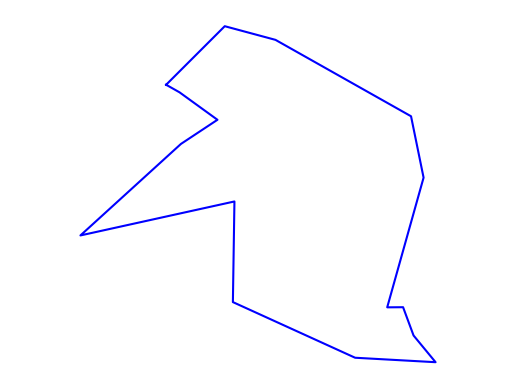

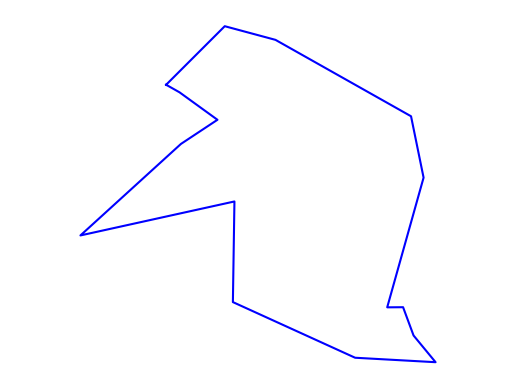

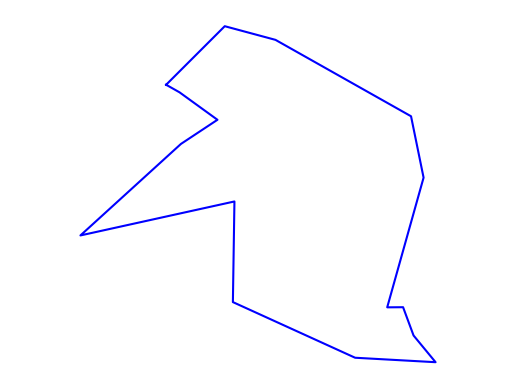

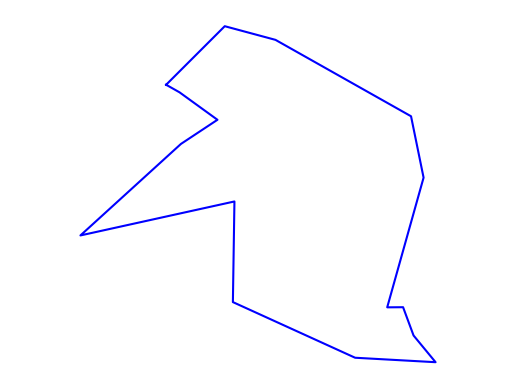

1.24 s ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit solve_static_way(l, True)

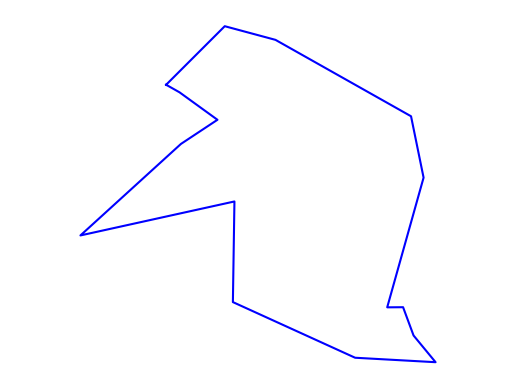

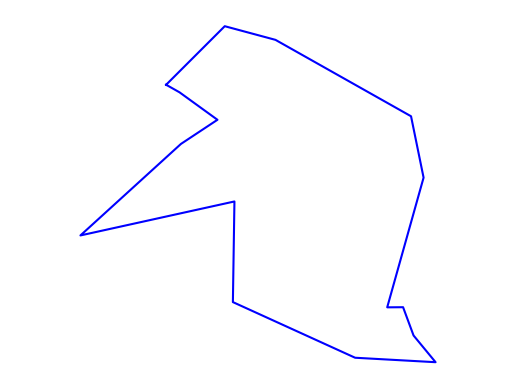

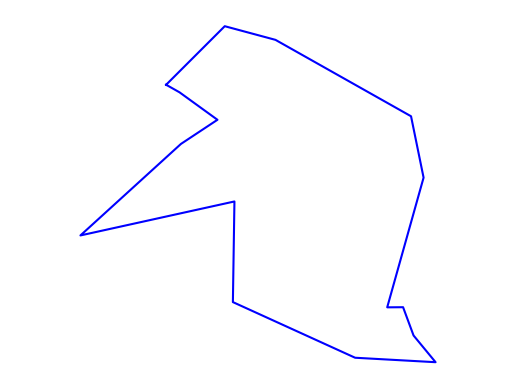

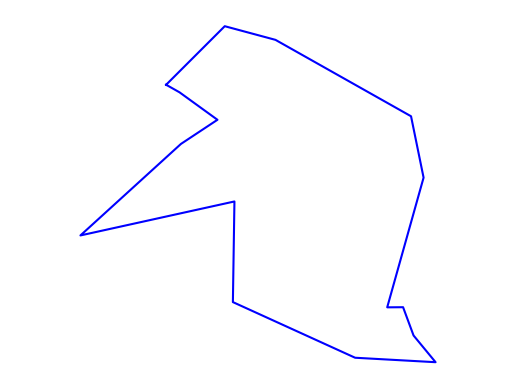

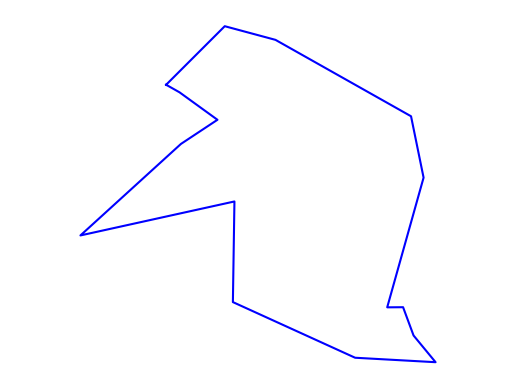

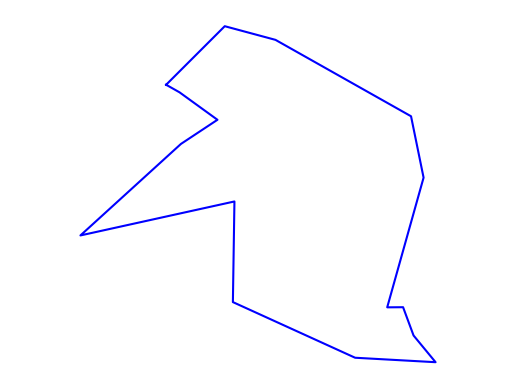

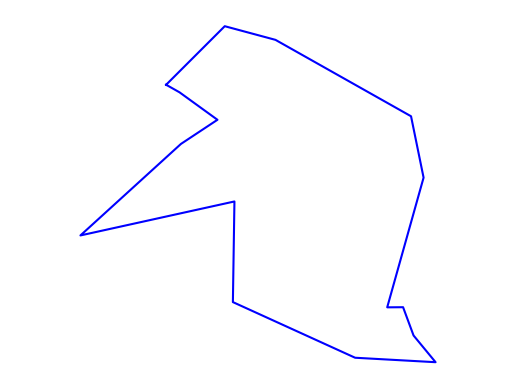

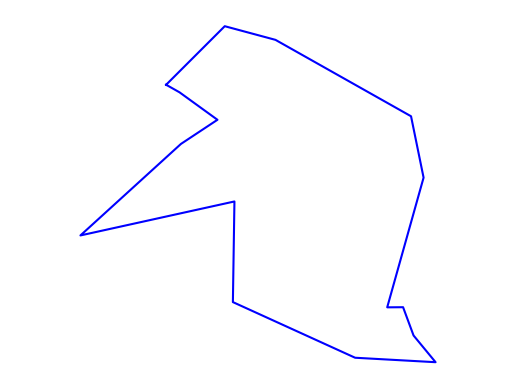

1.17 s ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit solve_static_way(l, False)